In [1]:
# Importing dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Importing dependencies
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Importing Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflecting an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Saving references to each table
measurement_ref = Base.classes.measurement
station_ref = Base.classes.station

In [8]:
# Creating the session (link) from Python to the database
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Finding the most recent date in the data set
session.query(measurement_ref.date).order_by(measurement_ref.date.desc()).first()

('2017-08-23',)

In [10]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results
# Starting from the most recent data point in the database, 2017-08-23
# Calculating the date one year from the last date in data set
dt.date(2017, 8, 23) - dt.timedelta(days=365)

datetime.date(2016, 8, 23)

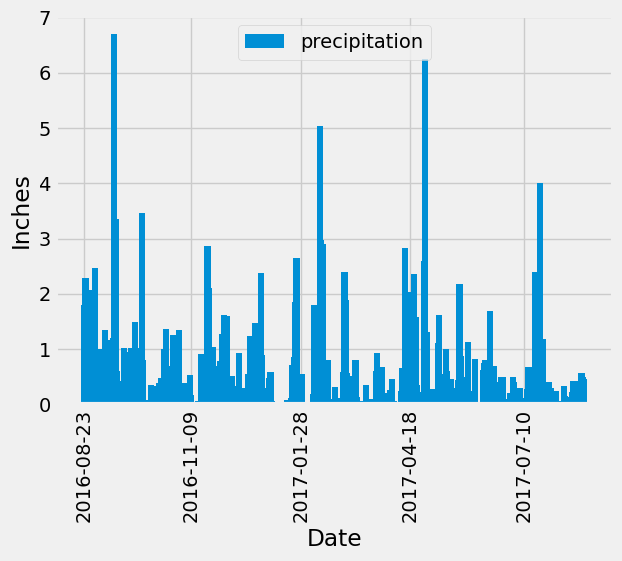

In [11]:
# Performing a query to retrieve the data and precipitation scores
date_and_prcp = session.query(measurement_ref.date, measurement_ref.prcp).\
    filter(measurement_ref.date <= '2017-08-23').\
    filter(measurement_ref.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_and_prcp_df = pd.DataFrame(date_and_prcp, columns=['date', 'precipitation'])

# Sort the dataframe by date
sorted_by_date_df = date_and_prcp_df.sort_values('date').reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(x = sorted_by_date_df['date'],
        height = sorted_by_date_df['precipitation'],
        width = 4.5)
plt.xticks(ticks = sorted_by_date_df['date'][::500],
           labels = sorted_by_date_df['date'][::500],
           rotation = 'vertical')
# https://stackoverflow.com/questions/62509338/show-only-some-bar-labels-for-matplotlib-bar-chart
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'], loc = 'upper center')
plt.show()

In [12]:
# Using Pandas to calculate the summary statistics for the precipitation data
prcp_count = sorted_by_date_df['precipitation'].count()
prcp_mean = sorted_by_date_df['precipitation'].mean()
prcp_std = sorted_by_date_df['precipitation'].std()
prcp_min = sorted_by_date_df['precipitation'].min()
quartiles = sorted_by_date_df['precipitation'].quantile([0.25, 0.5, 0.75])
lowerq = quartiles[0.25]
middleq = quartiles[0.5]
upperq = quartiles[0.75]
prcp_max = sorted_by_date_df['precipitation'].max()
prcp_summary_stats_df = pd.DataFrame()
prcp_summary_stats_df['precipitation'] = {'count': prcp_count,
                                          'mean': prcp_mean,
                                          'std': prcp_std,
                                          'min': prcp_min,
                                          '25%': lowerq,
                                          '50%': middleq,
                                          '75%': upperq,
                                          'max': prcp_max}
prcp_summary_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Designing a query to calculate the total number of stations in the dataset
session.query(func.count(func.distinct(measurement_ref.station))).scalar()

9

In [14]:
# Designing a query to find the most active stations (i.e. which stations have the most rows?)
# Listing the stations and their counts in descending order
session.query(measurement_ref.station, func.count(measurement_ref.station)).\
    group_by(measurement_ref.station).\
    order_by(func.count(measurement_ref.station).desc()).\
    all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, to calculate the lowest, highest, and average temperature
session.\
query(func.min(measurement_ref.tobs), func.max(measurement_ref.tobs), func.avg(measurement_ref.tobs)).\
filter(measurement_ref.station=='USC00519281').\
all()

[(54.0, 85.0, 71.66378066378067)]

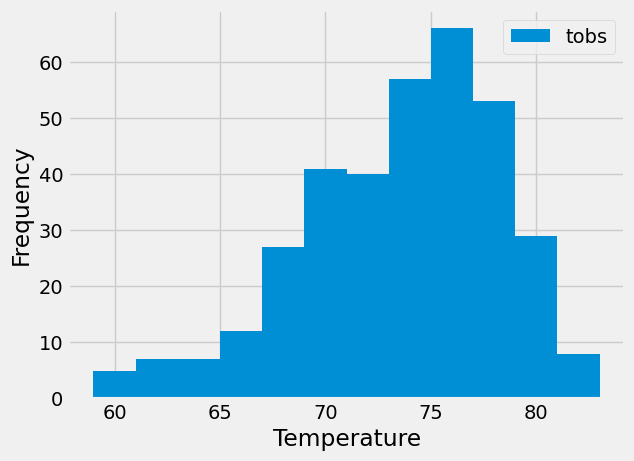

In [16]:
# Using the most active station id
# Querying the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(measurement_ref.tobs).\
    filter(measurement_ref.date <= '2017-08-23').\
    filter(measurement_ref.date >= '2016-08-23').\
    filter(measurement_ref.station=='USC00519281').\
    all()
temps_df = pd.DataFrame(temps)
plt.hist(x = temps_df, bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc = 'upper right')
plt.show()

# Close Session

In [17]:
# Closing the session
session.close()